In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# run pip install aif360
from aif360.sklearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score


pip install 'aif360[LawSchoolGPA]'


In [2]:
# Fetching adult dataset
adult = fetch_adult(numeric_only=True)
adult_parameters = adult.X
adult_income = adult.y
X = adult.X.values
y = adult_income.values
# Combination of input output
Xy = np.append(X, y[:, None], axis=1)
columns = ["age", "education", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]


In [41]:
# Fetching diabetes dataset
diabetes = pd.read_csv('diabetes_dataset.csv')
columns = list(diabetes.keys())
X = diabetes.values[:,:-1]
X[:,0] = X[:,0] > 0
y = (diabetes.values[:,-1]!=1).astype(int)
Xy = np.append(X, y[:, None], axis=1)

In [24]:
# Fetching compas dataset
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
model_df = df[['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'two_year_recid']]
for x in ['sex', 'race', 'c_charge_degree']:
 one_hot = pd.get_dummies(model_df[x], prefix=x)
 model_df = model_df.drop(x,axis = 1)
 model_df = model_df.join(one_hot)

y = np.array(model_df['two_year_recid'])
model_df = model_df.drop('two_year_recid', axis = 1)
columns = list(model_df.columns)
X = np.array(model_df)
Xy = np.append(X, y[:, None], axis=1)
print(columns)

['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'c_charge_degree_F', 'c_charge_degree_M']


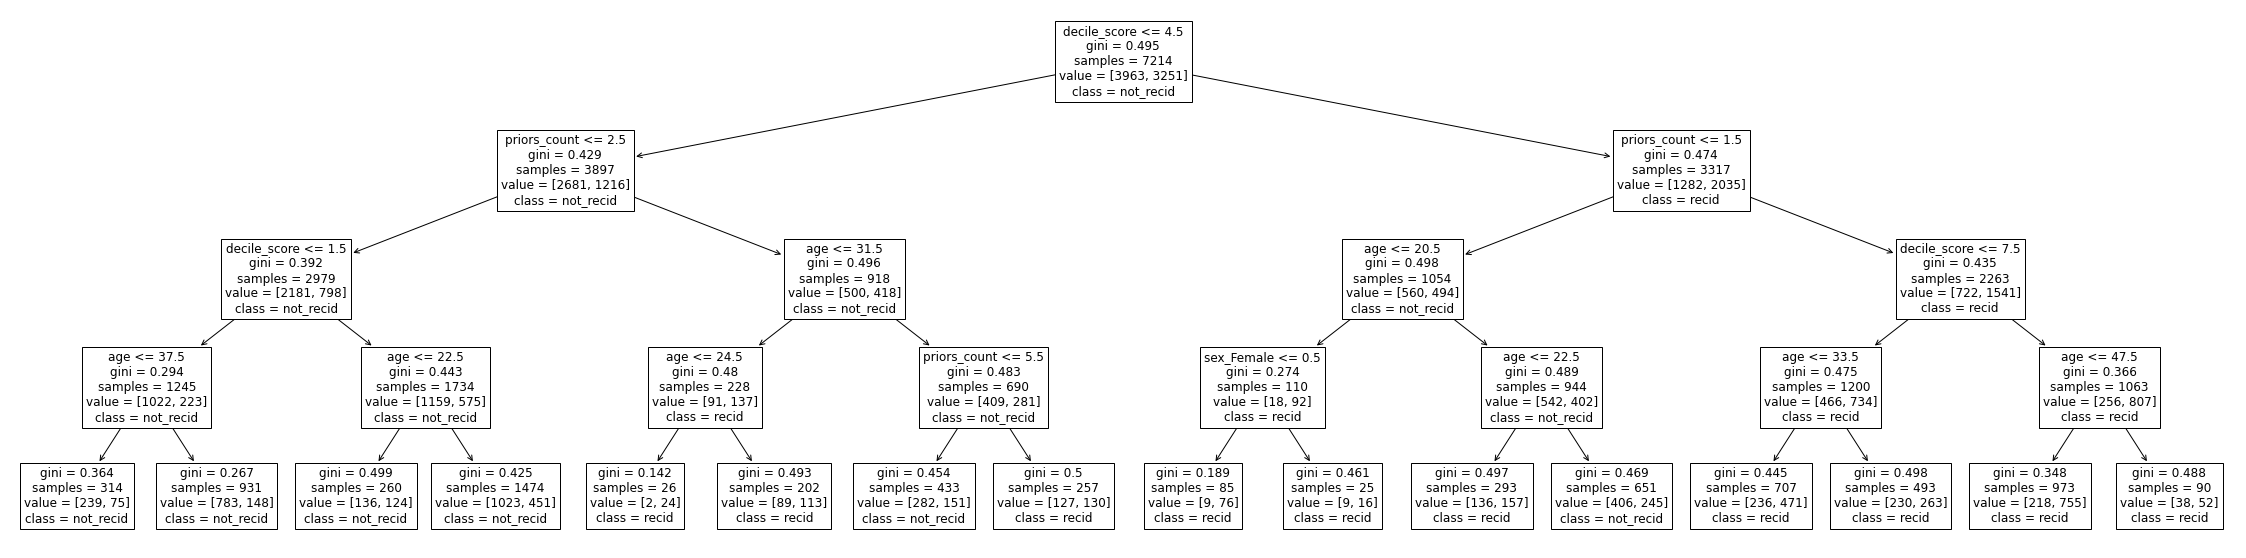

In [14]:
# Create a discriminative (but accurate) tree via sklearn
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X, y)
plt.figure(figsize=(40,10))
tree.plot_tree(clf, fontsize=12, feature_names=columns, class_names=["not_recid","recid"])
plt.show()

In [15]:
def discrimination(data, discriminatory_index):
    return statParity_equalOdds(data, discriminatory_index)

def accuracy(data):
    correct = 0
    for datum in data:
        if datum[-1] == datum[-2]:
            correct+=1
    return correct / len(data)

def statisticalParity(data, protectedIndex):
    if type(data) == list:
        data = np.array(data)
    protectedClass = data[np.where(data[:,protectedIndex]==0)]
    elseClass = data[np.where(data[:,protectedIndex]!=0)]
 
    if len(protectedClass) == 0 or len(elseClass) == 0:
        print("protectedClass or elseClass is empty")
        return 0
    else:
        protectedProb = np.count_nonzero(protectedClass[:,-1]) / len(protectedClass)
        elseProb = np.count_nonzero(elseClass[:,-1]) / len(elseClass)
 
    return protectedProb-elseProb

def equalizedOdds(data, protectedIndex):
    if type(data) == list:
        data = np.array(data)
    protectedClass = data[np.where(data[:,protectedIndex]==0)]
    protectedClass = protectedClass[np.where(protectedClass[:,-1]==protectedClass[:,-2])]
    elseClass = data[np.where(data[:,protectedIndex]!=0)]
    elseClass = elseClass[np.where(elseClass[:,-1]==elseClass[:,-2])]
 
    if len(protectedClass) == 0 or len(elseClass) == 0:
        print("protectedClass or elseClass is empty")
        return 0
    else:
        protectedProb = np.count_nonzero(protectedClass[:,-1]) / len(protectedClass)
        elseProb = np.count_nonzero(elseClass[:,-1]) / len(elseClass)

    return protectedProb-elseProb

def statParity_equalOdds(data, protectedIndex):
    if type(data) == list:
        data = np.array(data)
    protectedClass = data[np.where(data[:,protectedIndex]==0)]
    elseClass = data[np.where(data[:,protectedIndex]!=0)]
 
    if len(protectedClass) == 0 or len(elseClass) == 0:
        print("protectedClass or elseClass is empty")
        return 0
    else:
        protectedProb = np.count_nonzero(protectedClass[:,-1]) / len(protectedClass)
        elseProb = np.count_nonzero(elseClass[:,-1]) / len(elseClass)
 
    statParity = protectedProb-elseProb

    protectedClass = protectedClass[np.where(protectedClass[:,-1]==protectedClass[:,-2])]
    elseClass = elseClass[np.where(elseClass[:,-1]==elseClass[:,-2])]
 
    if len(protectedClass) == 0 or len(elseClass) == 0:
        print("protectedClass or elseClass is empty")
        return 0
    else:
        protectedProb = np.count_nonzero(protectedClass[:,-1]) / len(protectedClass)
        elseProb = np.count_nonzero(elseClass[:,-1]) / len(elseClass)

    equalOdds = protectedProb-elseProb

    return (equalOdds + statParity)/2

In [43]:
class Node:
    def __init__(self, leaf=None, feature=None, threshold=None, greater_node=None, less_node=None, data=None, gain=None):
        '''
        leaf: predicted class or None (if not leaf)
        feature: index of data node is comparing
        threshold: value of data node is comparing
        greater_node: greater node pointer
        less_node: less node pointer
        data: list of numpy arrays containing [attributes, true class, prediction]
        height: number of nodes above leaf
        gain: information/discrimination gain for training DT
        unique_id: random float for identifying parent/child relationship  
        '''
        self.leaf = leaf
        self.feature = feature
        self.threshold = threshold
        self.greater_node = greater_node
        self.less_node = less_node
        self.data = None
        if data == None:
            self.data = []
        else:
            self.data = data
        self.height = None
        self.gain = gain
        self.unique_id = np.random.random((1))[0]
    
    def add_greater_node(self, greater_node):
        self.greater_node = greater_node

    def add_less_node(self, less_node):
        self.less_node = less_node
    
    def is_leaf(self):
        return self.leaf != None

    def __repr__(self):
        if self.is_leaf():
            return "{class="+str(self.leaf)+"}"
        return "{"+str(self.feature)+"<="+str(self.threshold)+":"+str(self.less_node)+","+str(self.feature)+"<="+str(self.threshold)+":"+str(self.greater_node)+"}"
    
    def __str__(self):
        if self.is_leaf():
            return "{class="+str(self.leaf)+"}"
        return "{"+str(self.feature)+"<="+str(self.threshold)+":"+str(self.less_node)+","+str(self.feature)+"<="+str(self.threshold)+":"+str(self.greater_node)+"}"
    
    def export_json(self, attributes=None):
        if self.is_leaf():
            return {"class":self.leaf}
        if attributes == None:
            return {str(self.feature)+"<="+str(self.threshold):self.less_node.export_json(), str(self.feature)+">"+str(self.threshold):self.greater_node.export_json()}
        return {attributes[self.feature]+"<="+str(self.threshold):self.less_node.export_json(attributes), attributes[self.feature]+">"+str(self.threshold):self.greater_node.export_json(attributes)}


    def add_data(self, data):
        '''
        data: numpy array containing attributes and true class
        add_data: goes through the tree recursively appending data to each node with the predicted value
        return: predicted class
        '''
        if not self.is_leaf():
            if data[self.feature] <= self.threshold:
                leaf = self.less_node.add_data(data)
            else:
                leaf = self.greater_node.add_data(data)
            data = np.append(data, leaf)
            self.data.append(data)
            return leaf
        else:
            data = np.append(data, self.leaf)
            self.data.append(data)
            return self.leaf
        
    def get_prediction(self, data):
        '''
        data: numpy array containing attributes (true class optional)
        return: predicted class
        '''
        if not self.is_leaf():
            if data[self.feature] <= self.threshold:
                return self.less_node.get_prediction(data)
            else:
                return self.greater_node.get_prediction(data)
        else:
            return self.leaf

    
    def get_leafs(self):
        '''
        return: list of leaf Nodes
        '''

        if self.is_leaf():
            return [self]
        leafs = []
        leafs.extend(self.less_node.get_leafs())
        leafs.extend(self.greater_node.get_leafs())
        return leafs

    def get_height(self, overwrite=False):
        '''
        overwrite: boolean on whether to recalculate height (if not already saved)
        return: height of node
        '''
        if self.height != None and overwrite==False:
            return self.height
        elif self.is_leaf():
            return 0
        else:
            self.height = max(self.less_node.get_height(overwrite), self.greater_node.get_height(overwrite)) + 1
            return self.height

    def get_layer(self, height):
        '''
        height: target node height
        return: list of nodes of given height
        '''
        if self.get_height() == height:
            return [self]
        elif self.get_height() < height:
            return []
        else:
            temp = self.less_node.get_layer(height)
            temp.extend(self.greater_node.get_layer(height))
            return temp

    def reset_data(self, height=False):
        '''
        height: boolean reset height
        reset_data: clean wipe of data
        '''
        if self.is_leaf():
            self.data = []
            if height:
                self.height = None
        else:
            self.data = []
            if height:
                self.height = None
            self.less_node.reset_data(height)
            self.greater_node.reset_data(height)

    def copy(self, copy_data=False):
        '''
        copy_data: boolean copy data
        return: recursive copy of node
        '''
        data = []
        if copy_data:
            for datum in self.data:
                data.append(np.copy(self.datum))
        if self.is_leaf():
            copy = Node(self.leaf, self.feature, self.threshold, data=data)
            return copy
        else:
            copy = Node(self.leaf, self.feature, self.threshold, data=data)
            if self.less_node != None:
                copy.add_greater_node(self.greater_node.copy(copy_data))
            if self.greater_node != None:
                copy.add_less_node(self.less_node.copy(copy_data))
            return copy

    def discrimination(self, disc_index, disc_func=statisticalParity):
        '''
        disc_index: discriminatory index
        disc_fun: function to calculate discrimination
        return: discrimination
        '''
        return disc_func(self.data, disc_index)

    def accuracy(self, acc_func=accuracy):
        '''
        acc_func: functin to calculate accuracy
        return: accuracy
        '''
        return acc_func(self.data)
    
    def get_worst_node(self, disc_index, disc_func=statisticalParity, stats=False):
        '''
        disc_index: index of discriminatory attribute
        disc_fun: function used for discrimination calculation
        stats: boolean prints statistics about bad node
        get_worst_node: returns the node with worst discrimination
        return: node
        '''
        if self.is_leaf():
            return None
        worst_disc = self.discrimination(disc_index, disc_func=disc_func)
        worst_node = self
        if self.less_node != None:
            less_node = self.less_node.get_worst_node(disc_index, disc_func, stats)
            if less_node != None and worst_disc > less_node.discrimination(disc_index, disc_func):
                worst_node = less_node
                worst_disc = less_node.discrimination(disc_index, disc_func)
        if self.greater_node != None:
            greater_node = self.greater_node.get_worst_node(disc_index, disc_func, stats)
            if greater_node != None and worst_disc > greater_node.discrimination(disc_index, disc_func):
                worst_node = greater_node
                worst_disc = greater_node.discrimination(disc_index, disc_func)
        if stats:
                print("worst node:\n"+str(worst_node))
                print("discrimination:", worst_node.discrimination(disc_index, disc_func))
                print("accuracy", worst_node.accuracy())
        return worst_node

    def get_bad_nodes_child_method(self, comp, disc_index, disc_func=statisticalParity, stats=False):
        '''
        comp: discrimination score to be identified as bad (None sets comp to root's discrimination)
        disc_index: index of discriminatory attribute
        disc_func: function used for discrimination
        stats: boolean prints statistics about bad node
        get_bad_nodes_child_method: identifies bad node as one who's children are both labeled as bad which is when:
            discrimination is worse than comp (or is leaf and parent's discrimination is worse than comp)
        return: list of bad nodes
        '''
        bad_nodes = []
        if comp == None:
            comp = self.discrimination(disc_index, disc_func)
        if (self.less_node.is_leaf() and self.discrimination(disc_index, disc_func) < comp) or (not self.less_node.is_leaf() and self.less_node.discrimination(disc_index) < comp):
            if (self.greater_node.is_leaf() and self.discrimination(disc_index, disc_func) < comp) or (not self.greater_node.is_leaf() and self.greater_node.discrimination(disc_index) < comp):
                if stats:
                    print("bad node:\n"+str(self))
                    print("discrimination:", self.discrimination(disc_index, disc_func))
                    print("accuracy", self.accuracy())
                return [self]
        if not self.less_node.is_leaf():
            bad_nodes.extend(self.less_node.get_bad_nodes_child_method(comp, disc_index, disc_func, stats))
        if not self.greater_node.is_leaf():
            bad_nodes.extend(self.greater_node.get_bad_nodes_child_method(comp, disc_index, disc_func, stats))
        return bad_nodes

    def retrain_node(self, depth=None, stats=False, train_method=None, disc_index=None):
        '''
        depth: max depth of new tree (None if use node's current height)
        stats: boolean prints statistics
        retrain_node: uses the data stored in the node to train a new tree
        train_method: function used instead of information gain for training
        disc_index: Index of discriminatory class
        return: new tree node
        '''
        if depth == None:
            depth = self.get_height()
        fair_model = DecisionTreeFair(max_depth=depth-1,train_method=train_method, protected_index=disc_index)
        data = np.array(self.data)
        fair_model.fit(data[:,:-2], data[:,-2])
        if stats:
            print(fair_model.get_nodes())
            fair_preds = fair_model.predict(data[:,:-2])
            print('accuracy',accuracy_score(data[:,-2], fair_preds))
            xyz_fair = np.append(data[:,:-2], data[:,-2][:,None], axis=1)
            xyz_fair = np.append(xyz_fair, np.array(fair_preds)[:,None], axis=1)
            print('discrimination', statisticalParity(xyz_fair, 3))
        return fair_model.get_nodes()
    
    def get_parent(self, unique_id, height=None):
        '''
        unique_id: id of child node to match
        height: optional variable to help accelerate child identification
        return: parent node
        '''
        if self.is_leaf():
            return None
        elif height != None:
            potential_parents = self.get_layer(height)
            for parent in potential_parents:
                if parent.less_node.unique_id == unique_id or parent.greater_node.unique_id == unique_id:
                    return parent                
        elif self.less_node.unique_id == unique_id or self.greater_node.unique_id == unique_id:
            return self
        else:
            less_node = self.less_node.get_parent(unique_id)
            if less_node != None:
                return less_node
            greater_node = self.greater_node.get_parent(unique_id)
            if greater_node != None:
                return greater_node
        return None
    
    def replace_child(self, unique_id, node):
        '''
        unique_id: id of child
        node: node to replace child
        replace_child: swaps a current child with a new node
        '''
        if self.less_node.unique_id == unique_id:
            self.less_node = node
        elif self.greater_node.unique_id == unique_id:
            self.greater_node = node

    def simplify(self):
        '''
        simplify: if leafs are the same then become leaf
        '''
        if not self.is_leaf():
            self.less_node.simplify()
            self.greater_node.simplify()
            if self.less_node.leaf != None and self.less_node.leaf == self.greater_node.leaf:
                self.leaf = self.less_node.leaf
        

In [17]:
def entropy(s):
    '''
    Helper function, calculates entropy from an array of integer values.
    
    :param s: list
    :return: float, entropy value
    '''
    # Convert to integers to avoid runtime errors
    counts = np.bincount(np.array(s, dtype=np.int64))
    # Probabilities of each class label
    percentages = counts / len(s)

    # Caclulate entropy
    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy += pct * np.log2(pct)
    return -entropy

def avg_statParity_equalOdds(left_child, right_child, left_pred, right_pred, protectedIndex):
    left_child = np.insert(left_child, -1, left_pred, axis=1)
    right_child = np.insert(right_child, -1, right_pred, axis=1)
    data = np.append(left_child, right_child, axis=0)
    protectedClass = data[np.where(data[:,protectedIndex]==0)]
    elseClass = data[np.where(data[:,protectedIndex]!=0)]

    if len(protectedClass) == 0 or len(elseClass) == 0:
        return -1
    else:
        protectedProb = np.count_nonzero(protectedClass[:,-1]) / len(protectedClass)
        elseProb = np.count_nonzero(elseClass[:,-1]) / len(elseClass)

    statParity = protectedProb-elseProb

    protectedClass = protectedClass[np.where(protectedClass[:,-1]==protectedClass[:,-2])]
    elseClass = elseClass[np.where(elseClass[:,-1]==elseClass[:,-2])]

    if len(protectedClass) == 0 or len(elseClass) == 0:
        return -1
    else:
        protectedProb = np.count_nonzero(protectedClass[:,-1]) / len(protectedClass)
        elseProb = np.count_nonzero(elseClass[:,-1]) / len(elseClass)

    equalOdds = protectedProb-elseProb

    return (equalOdds + statParity)/2

def information_gain(parent, left_child, right_child):
    '''
    Helper function, calculates information gain from a parent and two child nodes.
    
    :param parent: list, the parent node
    :param left_child: list, left child of a parent
    :param right_child: list, right child of a parent
    :return: float, information gain
    '''
    num_left = len(left_child) / len(parent)
    num_right = len(right_child) / len(parent)
    
    # One-liner which implements the previously discussed formula
    return entropy(parent) - (num_left * entropy(left_child) + num_right * entropy(right_child))


def gain_calc(df_left, df_right, protected_index):
    y = np.append(df_left, df_right, axis=0)[:, -1]
    y_left = df_left[:, -1]
    y_right = df_right[:, -1]
    pred_left = np.average(y_left) > 0.5
    pred_right = np.average(y_right) > 0.5
    # Caclulate the information gain and save the split parameters
    # if the current split if better then the previous best
    info_gain = information_gain(y, y_left, y_right)
    discrimination = avg_statParity_equalOdds(df_left, df_right, pred_left, pred_right, protected_index)
    gain = (info_gain + discrimination + 1)/2
    return gain

def gain_disc_priority(df_left, df_right, protected_index):
    y = np.append(df_left, df_right, axis=0)[:, -1]
    y_left = df_left[:, -1]
    y_right = df_right[:, -1]
    pred_left = np.average(y_left) > 0.5
    pred_right = np.average(y_right) > 0.5
    # Caclulate the information gain and save the split parameters
    # if the current split if better then the previous best
    info_gain = information_gain(y, y_left, y_right)
    discrimination = avg_statParity_equalOdds(df_left, df_right, pred_left, pred_right, protected_index)
    gain = (info_gain + 3*discrimination + 2)/4
    return gain

def gain_info_priority(df_left, df_right, protected_index):
    y = np.append(df_left, df_right, axis=0)[:, -1]
    y_left = df_left[:, -1]
    y_right = df_right[:, -1]
    pred_left = np.average(y_left) > 0.5
    pred_right = np.average(y_right) > 0.5
    # Caclulate the information gain and save the split parameters
    # if the current split if better then the previous best
    info_gain = information_gain(y, y_left, y_right)
    discrimination = avg_statParity_equalOdds(df_left, df_right, pred_left, pred_right, protected_index)
    gain = (3*info_gain + discrimination + 2)/4
    return gain


In [18]:
class DecisionTreeFair:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5, train_method=None, protected_index=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.train_method = train_method
        self.protected_index = protected_index
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_gain = -float('inf')
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    if self.train_method == None:
                        gain = gain_calc(df_left, df_right, self.protected_index)
                    else:
                        gain = self.train_method(df_left, df_right, self.protected_index)
                    if gain > best_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1],
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1],
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    less_node=left, 
                    greater_node=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            leaf=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.leaf != None:
            return tree.leaf
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.less_node)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.greater_node)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

    def get_nodes(self):
        return self.root

In [19]:
def export_dict(clf):
    '''
    clf: sklearn decision tree
    return: node decision tree
    '''
    return export_dict_rec(tree.export_text(clf)[0:-1])
def export_dict_rec(tree_text):
    '''
    tree_text: string in the format of sklearn export text
    return: node decision tree
    '''
    if tree_text[0:12] == "|--- class: " or tree_text.find("feature") == -1:
        return Node(float(tree_text[12:]), None, None)
    tree_text = tree_text.replace("|--- feature_", "", 1)
    tree_text = tree_text.replace("\n|--- feature_", "\n", 1)
    tree_text = tree_text.replace("\n|   ", "\n")
    features = []
    feature = ""
    for letter in tree_text:
        if letter == " " or letter == "\n":
            features.append(feature)
            feature = ""
            if letter == "\n":
                break
        else:
            feature+=letter
    start = tree_text.find("\n")
    start_end = tree_text.find("\n"+tree_text[0])
    end = start_end+tree_text[start_end:].find("\n|")
    tree = Node(None, int(features[0]), float(features[-1]))
    tree.add_less_node(export_dict_rec(tree_text[start+1:start_end]))
    tree.add_greater_node(export_dict_rec(tree_text[end+1:]))
    return tree

In [20]:
def predictive_similarity(before, after):
    '''
    before: list of numpy arrays containing attributes, true class, and predictions
    after: list of numpy arrays containing attributes, true class, and predictions
    predictive_similarity: compares the predictions and checks how many stayed the same
    return: ratio of unchanged predictions
    '''
    initial_preds = []
    for data in before:
        initial_preds.append(data[-1])
    initial_preds = np.array(initial_preds)
    final_preds = []
    for data in after:
        final_preds.append(data[-1])
    final_preds = np.array(final_preds)
    return np.average(initial_preds==final_preds)    

def naive_discounted_similarity(before, after, discount=0.7, min_feature_score=0.5):
    if before == None or after == None:
        return 0
    if before.is_leaf() and after.is_leaf():
        return before.leaf == after.leaf
    if before.is_leaf() or after.is_leaf():
        return 0
    naive_score = 0
    if before.feature == after.feature:
        naive_score = min_feature_score
        naive_score += 0.5 * min(before.threshold, after.threshold)/max(before.threshold, after.threshold)
    return (1-discount)*naive_score+discount*0.5*(naive_discounted_similarity(before.less_node, after.less_node, discount, min_feature_score)+naive_discounted_similarity(before.greater_node, after.greater_node, discount, min_feature_score))

In [21]:
tree_dict = export_dict(clf)
for data in Xy:
    tree_dict.add_data(data)
print(tree_dict.export_json(columns))
tree_dict.simplify()
print(tree_dict.export_json(columns))

{'decile_score<=4.5': {'priors_count<=2.5': {'decile_score<=1.5': {'age<=37.5': {'class': 0.0}, 'age>37.5': {'class': 0.0}}, 'decile_score>1.5': {'age<=22.5': {'class': 0.0}, 'age>22.5': {'class': 0.0}}}, 'priors_count>2.5': {'age<=31.5': {'age<=24.5': {'class': 1.0}, 'age>24.5': {'class': 1.0}}, 'age>31.5': {'priors_count<=5.5': {'class': 0.0}, 'priors_count>5.5': {'class': 1.0}}}}, 'decile_score>4.5': {'priors_count<=1.5': {'age<=20.5': {'sex_Female<=0.5': {'class': 1.0}, 'sex_Female>0.5': {'class': 1.0}}, 'age>20.5': {'age<=22.5': {'class': 1.0}, 'age>22.5': {'class': 0.0}}}, 'priors_count>1.5': {'decile_score<=7.5': {'age<=33.5': {'class': 1.0}, 'age>33.5': {'class': 1.0}}, 'decile_score>7.5': {'age<=47.5': {'class': 1.0}, 'age>47.5': {'class': 1.0}}}}}
{'decile_score<=4.5': {'priors_count<=2.5': {'class': 0.0}, 'priors_count>2.5': {'age<=31.5': {'class': 1.0}, 'age>31.5': {'priors_count<=5.5': {'class': 0.0}, 'priors_count>5.5': {'class': 1.0}}}}, 'decile_score>4.5': {'priors_coun

In [22]:
tree_dict = export_dict(clf)
tree_dict.simplify()
for data in Xy:
    tree_dict.add_data(data)

fair_model = DecisionTreeFair(max_depth=3, train_method=gain_disc_priority, protected_index=3)
fair_model.fit(X, y)
for data in Xy:
    fair_model.root.add_data(data)
fair_model.root.simplify()
print('predictive similarity:', predictive_similarity(tree_dict.data, fair_model.root.data), 'naive discounted similarity:', naive_discounted_similarity(tree_dict, fair_model.root))



predictive similarity: 0.6097865261990574 naive discounted similarity: 0.09187500000000001


In [44]:
disc_index = 8
tree_dict = export_dict(clf)
tree_dict.simplify()
for data in Xy:
    tree_dict.add_data(data)
initial_data = tree_dict.data
initial_tree = tree_dict.copy()
print(tree_dict.export_json(columns))

print('BEFORE: accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(disc_index))
print(tree_dict.discrimination(disc_index), tree_dict.less_node.discrimination(disc_index), tree_dict.greater_node.discrimination(disc_index))
print()

bad_nodes = tree_dict.get_bad_nodes_child_method(-0.075, disc_index)
i=0
for bad_node in bad_nodes:
    print('bad node:', bad_node.export_json(columns))
    print('bad node accuracy:', bad_node.accuracy(), 'discrimination:', bad_node.discrimination(disc_index))
    good_node = bad_node.retrain_node(depth=None, stats=False, train_method=gain_disc_priority, disc_index=disc_index)
    good_node.simplify()
    print('good node', good_node.export_json(columns))
    for data in bad_node.data:
        good_node.add_data(data[:-1])
    print(np.array(good_node.data).shape, np.array(bad_node.data).shape)
    print('good node accuracy:', good_node.accuracy(), 'discrimination:', good_node.discrimination(disc_index))
    prev = good_node.unique_id
    if bad_node.unique_id == tree_dict.unique_id:
        tree_dict = good_node
    else:
        parent_node = tree_dict.get_parent(bad_node.unique_id, bad_node.get_height()+1)
        parent_node.replace_child(bad_node.unique_id, good_node)
    tree_dict.reset_data()
    for data in Xy:
        tree_dict.add_data(data)
    i+=1
    print()
    print('Step '+str(i)+': accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(disc_index))
    print()
tree_dict.simplify()
tree_dict.reset_data()
for data in Xy:
    tree_dict.add_data(data)
print()
print('AFTER: accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(disc_index))
print('predictive similarity:', predictive_similarity(initial_data, tree_dict.data), 'naive discounted similarity:', naive_discounted_similarity(initial_tree, tree_dict))
print(tree_dict.export_json(columns))

{'decile_score<=4.5': {'priors_count<=2.5': {'class': 0.0}, 'priors_count>2.5': {'age<=31.5': {'class': 1.0}, 'age>31.5': {'priors_count<=5.5': {'class': 0.0}, 'priors_count>5.5': {'class': 1.0}}}}, 'decile_score>4.5': {'priors_count<=1.5': {'age<=20.5': {'class': 1.0}, 'age>20.5': {'age<=22.5': {'class': 1.0}, 'age>22.5': {'class': 0.0}}}, 'priors_count>1.5': {'class': 1.0}}}
BEFORE: accuracy 0.6828389243138342 discrimination -0.2500139972780678
-0.2500139972780678 -0.07609101597620858 -0.07698594943341375

bad node: {'decile_score<=4.5': {'priors_count<=2.5': {'class': 0.0}, 'priors_count>2.5': {'age<=31.5': {'class': 1.0}, 'age>31.5': {'priors_count<=5.5': {'class': 0.0}, 'priors_count>5.5': {'class': 1.0}}}}, 'decile_score>4.5': {'priors_count<=1.5': {'age<=20.5': {'class': 1.0}, 'age>20.5': {'age<=22.5': {'class': 1.0}, 'age>22.5': {'class': 0.0}}}, 'priors_count>1.5': {'class': 1.0}}}
bad node accuracy: 0.6828389243138342 discrimination: -0.2500139972780678
good node {'age<=40.0'

In [42]:
tree_dict = export_dict(clf)
# tree_dict.simplify()
for data in Xy:
    tree_dict.add_data(data)
initial_data = tree_dict.data
print(tree_dict.export_json(columns))

print('BEFORE: accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(3))
print(tree_dict.discrimination(disc_index), tree_dict.less_node.discrimination(disc_index), tree_dict.greater_node.discrimination(disc_index))
print()

bad_nodes = tree_dict.get_bad_nodes_child_method(None, 3)
i=0
for bad_node in bad_nodes:
    print('bad node:', bad_node.export_json(columns))
    print('bad node accuracy:', bad_node.accuracy(), 'discrimination:', bad_node.discrimination(3))
    good_node = bad_node.retrain_node(depth=None, stats=False, train_method=gain_disc_priority, disc_index=3)
    print('good node', good_node.export_json(columns))
    for data in bad_node.data:
        good_node.add_data(data)
    print('good node accuracy:', good_node.accuracy(), 'discrimination:', good_node.discrimination(3))
    prev = good_node.unique_id
    parent_node = tree_dict.get_parent(bad_node.unique_id, bad_node.get_height()+1)
    parent_node.replace_child(bad_node.unique_id, good_node)
    tree_dict.reset_data()
    for data in Xy:
        tree_dict.add_data(data)
    i+=1
    print()
    print('Step '+str(i)+': accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(3))
    print()
tree_dict.simplify()
tree_dict.reset_data()
for data in Xy:
    tree_dict.add_data(data)
print()
print('AFTER: accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(3), 'predictive similarity:', predictive_similarity(initial_data, tree_dict.data))
print(tree_dict.discrimination(disc_index), tree_dict.less_node.discrimination(disc_index), tree_dict.greater_node.discrimination(disc_index))
print(tree_dict.export_json(columns))

{'decile_score<=4.5': {'priors_count<=2.5': {'decile_score<=1.5': {'age<=37.5': {'class': 0.0}, 'age>37.5': {'class': 0.0}}, 'decile_score>1.5': {'age<=22.5': {'class': 0.0}, 'age>22.5': {'class': 0.0}}}, 'priors_count>2.5': {'age<=31.5': {'age<=24.5': {'class': 1.0}, 'age>24.5': {'class': 1.0}}, 'age>31.5': {'priors_count<=5.5': {'class': 0.0}, 'priors_count>5.5': {'class': 1.0}}}}, 'decile_score>4.5': {'priors_count<=1.5': {'age<=20.5': {'sex_Female<=0.5': {'class': 1.0}, 'sex_Female>0.5': {'class': 1.0}}, 'age>20.5': {'age<=22.5': {'class': 1.0}, 'age>22.5': {'class': 0.0}}}, 'priors_count>1.5': {'decile_score<=7.5': {'age<=33.5': {'class': 1.0}, 'age>33.5': {'class': 1.0}}, 'decile_score>7.5': {'age<=47.5': {'class': 1.0}, 'age>47.5': {'class': 1.0}}}}}
BEFORE: accuracy 0.6828389243138342 discrimination -0.536096749948208
-0.26281345684598134 -0.0740525337492284 -0.07987943796405539

protectedClass or elseClass is empty
protectedClass or elseClass is empty

AFTER: accuracy 0.682838

In [ ]:
tree_dict = export_dict(clf)
for data in Xy:
    tree_dict.add_data(data)
initial_data = tree_dict.data

print('BEFORE: accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(3))
print()

goal_discrimination = -0.1
i=0
prev = -1
while(tree_dict.discrimination(3) < goal_discrimination):
    bad_node = tree_dict.get_worst_node(3)
    if bad_node.unique_id == prev:
        print("repeated worst node")
        break
    print('bad node:', bad_node)
    print('bad node accuracy:', bad_node.accuracy(), 'discrimination:', bad_node.discrimination(3))
    good_node = bad_node.retrain_node(depth=None, stats=False, train_method=gain_disc_priority, disc_index=3)
    print('good node', good_node)
    for data in bad_node.data:
        good_node.add_data(data)
    print('good node accuracy:', good_node.accuracy(), 'discrimination:', good_node.discrimination(3))
    prev = good_node.unique_id
    parent_node = tree_dict.get_parent(bad_node.unique_id, bad_node.get_height()+1)
    parent_node.replace_child(bad_node.unique_id, good_node)
    tree_dict.reset_data()
    for data in Xy:
        tree_dict.add_data(data)
    i+=1
    print()
    if (tree_dict.discrimination(3) < goal_discrimination):
        print('Step '+str(i)+': accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(3))
        print()



print('AFTER: accuracy', tree_dict.accuracy(), 'discrimination', tree_dict.discrimination(3), 'predictive_similarity', predictive_similarity(initial_data, tree_dict.data))
print('predictive similarity:', predictive_similarity(initial_data, tree_dict.data), 'naive discounted similarity:', naive_discounted_similarity(initial_tree, tree_dict))
print(tree_dict.export_json(columns))


BEFORE: accuracy 0.8265222554358953 discrimination -0.20516789939003247

bad node: {3<=0.5:{class=0.0},3<=0.5:{class=1.0}}
bad node accuracy: 0.6197984588026082 discrimination: -1.0
good node {4<=4934.0:{class=1.0},4<=4934.0:{class=0.0}}
good node accuracy: 0.727089508002371 discrimination: -0.49873125812031827

Step 1: accuracy 0.8069898857540642 discrimination -0.10978719542586976

bad node: {4<=5316.5:{class=1.0},4<=5316.5:{0<=61.0:{class=0.0},0<=61.0:{class=1.0}}}
bad node accuracy: 0.9458483754512635 discrimination: -0.4572137987087444
good node {6<=75.0:{6<=6.0:{class=0.0},6<=6.0:{class=1.0}},6<=75.0:{class=0.0}}
good node accuracy: 0.6967509025270758 discrimination: 0.01816001871563927

Step 2: accuracy 0.8053519511895499 discrimination -0.10896136004042754

bad node: {0<=29.5:{0<=27.5:{class=0.0},0<=27.5:{class=0.0}},0<=29.5:{4<=4934.0:{class=1.0},4<=4934.0:{class=0.0}}}
bad node accuracy: 0.5880007418397626 discrimination: -0.2537120593855926
good node {0<=28.0:{0<=24.0:{class

In [ ]:
tree_dict.simplify()
print(tree_dict.export_json(columns))

{'capital-gain<=5119.0': {'education<=12.5': {'class': 0.0}, 'education>12.5': {'age<=28.0': {'class': 0.0}, 'age>28.0': {'capital-loss<=2415.0': {'class': 0.0}, 'capital-loss>2415.0': {'class': 1.0}}}}, 'capital-gain>5119.0': {'capital-gain<=7055.5': {'hours-per-week<=75.0': {'hours-per-week<=6.0': {'class': 0.0}, 'hours-per-week>6.0': {'class': 1.0}}, 'hours-per-week>75.0': {'class': 0.0}}, 'capital-gain>7055.5': {'age<=20.5': {'capital-gain<=24559.5': {'class': 1.0}, 'capital-gain>24559.5': {'class': 0.0}}, 'age>20.5': {'class': 1.0}}}}


In [ ]:
fair_model = DecisionTreeFair(max_depth=4, train_method=gain_disc_priority, protected_index=3)
fair_model.fit(X, y)
fair_preds = fair_model.predict(X)

In [ ]:
print(accuracy_score(y, fair_preds))
xyz_fair = np.append(X, y[:,None], axis=1)
xyz_fair = np.append(xyz_fair, np.array(fair_preds)[:,None], axis=1)
print(statParity_equalOdds(xyz_fair, 3))

0.7624790139633921
2.5533846746583332e-05
